# **Assignment 3 - Part B_1**

## **Low level: Using pure pytorch tensor data structure to build a 3 layer neural network without auto differentiation primitives**

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing

In [1]:
##Importing the required libraries
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Initializing weight matrix
data = [[1,2,3], [4,5,6]]
a = torch.tensor(data)
a.shape

torch.Size([2, 3])

In [3]:
##Initializing values for bias with appropriate dimensions
bias = [[1],[0.5]]
bias = torch.tensor(bias)
print(bias.shape)

torch.Size([2, 1])


In [4]:
##Generating 3d input and calculating y_true value
n = 500
d = 3
x = torch.rand(n, d)
a = a.T

## y1 = x_1^2 + 2 * x_2^2 + 3 * x_3^2 + x_1 + 2 * x_2 + 3 * x_3 + 1
## y2 = 4 * x_1^2 + 5 * x_2^2 + 6 * x_3^2 + 4 * x_1 + 5 * x_2 + 6 * x_3 + 0.5
##Calculating actual output for the data

y_true = torch.matmul(x.float().pow(2), a.float()) + torch.matmul(x.float(), a.float()) + bias.T.float()

##Checking shapes for input, weight, bias and output tensors
print(f'x: {x.shape}, weights: {a.shape}, bias: {bias.shape}, y: {y_true.shape}')

x: torch.Size([500, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([500, 2])


In [5]:
y_true.shape

torch.Size([500, 2])

In [6]:
##Visualizing the data distribution using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_jobs=5).fit_transform(x)
tsne.shape

(500, 2)

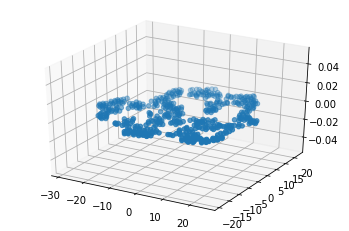

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [8]:
import math
import torch.nn as nn

##Defining customized loss function
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


##Defining custom linear layer
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.matmul(self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.matmul(gradient, self.weights.T)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


##Defining non - linear activation function reLu
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


##Defining the model class
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

##Calculating the loss 
loss = MSE()
model = TorchModel(d, 4)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(106.6485)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
##Function for tsne plot visualization
def tsne_plot(tsne, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne[:, 0], tsne[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(tsne[:, 0], tsne[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

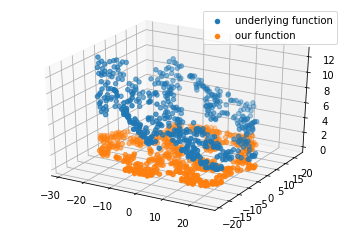

In [10]:
##Visualizing the data distribution using TSNE
tsne_plot(tsne, y_true, model(x_tensor).detach())

In [11]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

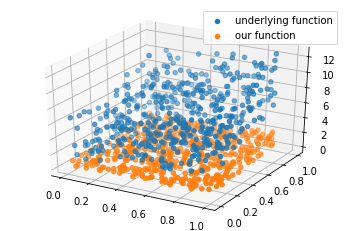

In [12]:
plot_3d(x, y_true, model(x_tensor).detach())

In [13]:
##Checking if loss is reducing
loss = MSE()
model = TorchModel(d, 10)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(90.7531)
tensor(58.2301)


In [14]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=50)

Epoch 0, loss 58.2301025390625
Epoch 1, loss 28.338247299194336
Epoch 2, loss 9.775818824768066
Epoch 3, loss 3.9243457317352295
Epoch 4, loss 3.0343897342681885
Epoch 5, loss 2.8767213821411133
Epoch 6, loss 2.788148880004883
Epoch 7, loss 2.711754560470581
Epoch 8, loss 2.6397249698638916
Epoch 9, loss 2.570042610168457
Epoch 10, loss 2.5020909309387207
Epoch 11, loss 2.4356689453125
Epoch 12, loss 2.3707046508789062
Epoch 13, loss 2.3071680068969727
Epoch 14, loss 2.2450428009033203
Epoch 15, loss 2.184311628341675
Epoch 16, loss 2.1249656677246094
Epoch 17, loss 2.066990613937378
Epoch 18, loss 2.0103750228881836
Epoch 19, loss 1.955105185508728
Epoch 20, loss 1.9011707305908203
Epoch 21, loss 1.8485580682754517
Epoch 22, loss 1.797252893447876
Epoch 23, loss 1.7472429275512695
Epoch 24, loss 1.6985142230987549
Epoch 25, loss 1.6510523557662964
Epoch 26, loss 1.6048427820205688
Epoch 27, loss 1.5598704814910889
Epoch 28, loss 1.5161207914352417
Epoch 29, loss 1.4735770225524902
Epo

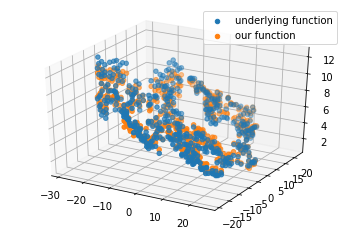

In [15]:
##Visualizing the data distribution using TSNE after training
tsne_plot(tsne, y_true, model(x_tensor).detach())

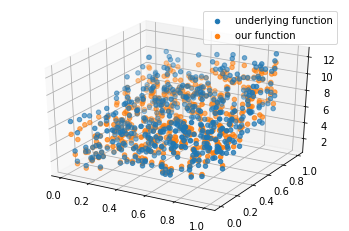

In [16]:
##Visualizing the shape of data after training
plot_3d(x, y_true, model(x_tensor).detach())

We can see how after training, the shape of the data before and after is now similar/overlapping